In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

# Links 
<a href='#0'>0) Presentation of the data<a/>
    
<a href='#1'>1) Treatment of the data<a/>

<a href='#2'>2) Data Analysis<a/>


<a id='0'><a/>
# 0) Presentation of the data

In [2]:
# We import the transaction data
trans=pd.read_csv('external_trans.csv', names=['time','value' ])

In [3]:
# We import the price data
price=pd.read_csv('POLY_price.csv')

In [4]:
price=price.loc[:,['close', 'time']]

We have imported two dataframes. `price` and `trans`. Containing the transaction data and the price data of the coin Polymath.

In [5]:
trans.head()

,time,value
0,2018-02-12 15:54:29+00:00,3.000000e+21
1,2018-02-12 16:06:46+00:00,1.500000e+21
2,2018-07-31 11:31:42+00:00,1.085375e+24
3,2018-07-31 11:31:50+00:00,5.387435e+23
4,2018-07-31 11:32:09+00:00,3.716889e+23


`trans` contains the transaction data. Namely the timestamps of the transactions between February 2018 and October 2019, and the amount of the transaction in number of POLY coins.

`price` contains the price data for polymath. The data is composed of the close value of POLY in ethereum on a hourly rate.

In [6]:
price.head()

,close,time
0,0.000261,1563267600
1,0.000261,1563271200
2,0.000264,1563274800
3,0.000280,1563278400
4,0.000272,1563282000


<a id='1'><a/>

# 1) Treatment of the data

In [7]:
# We convert the price dates into datetime objects
price.time=price.time.apply(lambda x: datetime.fromtimestamp(x))

In [8]:
# We sort the values by date and recreate the index.
price.sort_values('time', inplace=True)
price = price.reset_index(drop=True)

In [9]:
# We convert the transaction times to datetime objects.
trans.time=trans.time.apply(lambda x: datetime.strptime(x[:-6],'%Y-%m-%d %H:%M:%S'))

In [10]:
# We compute the returns of the closing prices
price.loc[:,'returns']= (price.close.shift()-price.close)/price.close

In [11]:
# We normalize the returns of the closing prices
price.loc[:,'returns']= (price.returns-price.returns.mean())/price.returns.std()

In [12]:
# We create bins of one hour intervals and we aggregate the transactions in the bins
cut = pd.cut(trans.time, bins= price.time, duplicates='drop')
trans_cut=trans.groupby(cut)['value'].aggregate(['count','sum'])

# We show 5 examples of intervals for readability
trans_cut.sample(5)

,count,sum
time,,
"(2018-12-22 22:00:00, 2018-12-22 23:00:00]",0,0.000000e+00
"(2019-05-24 22:00:00, 2019-05-24 23:00:00]",1,2.089750e+21
"(2019-04-07 19:00:00, 2019-04-07 20:00:00]",1,1.744249e+21
"(2019-03-08 08:00:00, 2019-03-08 09:00:00]",2,9.968280e+22
"(2019-04-13 06:00:00, 2019-04-13 07:00:00]",1,1.162800e+23


In [13]:
# We normalize the transaction volume per hour
trans_cut.loc[:,'sum']= ( trans_cut['sum']-trans_cut['sum'].mean() ) / trans_cut['sum'].std()

In [14]:
# We transform time from an index into a column in the dataframe
trans_cut.reset_index(level=0, inplace=True)

In [15]:
# We create a curated dataframe with the merged data
data = pd.DataFrame({'volume':trans_cut['sum'].shift(-1),
                    'returns':price.returns, 
                    'date':price.time})

In [16]:
# We show an example of the merged data. Data contains the houly returns of the price of polymath
# and the volume of the transactions in the preceding 1 hour interval (both normalized).
data.head()

,date,returns,volume
0,2018-05-25 19:00:00,NaN,-0.196579
1,2018-05-25 20:00:00,-2.610448,-0.196579
2,2018-05-25 21:00:00,1.088491,-0.196579
3,2018-05-25 22:00:00,0.727910,-0.196579
4,2018-05-25 23:00:00,-0.704423,-0.196579


In [17]:
# We remove the rows where one value is missing
data=data.dropna()

In [19]:
# We observe that there is no transaction volume for the first 1600 values
# and we drop the first 1600 values of data. This is until february 2019.
data.volume.values[:20]
data=data[1600:]
# We reset the indexes
data=data.reset_index(drop=True)

In [20]:
#There are two extreme values in the returns that are explained
# by a single strange value at 2019-08-11 03:00:00
#     display(price[10614:10619])
#     display(data[abs(data.returns)>=20])

In [21]:
# We drop the 2 rows with crazy returns
data=data.drop([9015,9016], axis=0)

In [66]:
# We compute the daily volume of transactions to plot it and we normalize it
daily_volume = data.resample('D', on='date').sum()['volume'] 
daily_volume = (daily_volume-daily_volume.mean())/ daily_volume.std()
daily_volume_days = data.resample('D', on='date').sum().index

<a id='2'><a/>
# 2) Data analysis

Text(0,0.5,'Normalized volume')

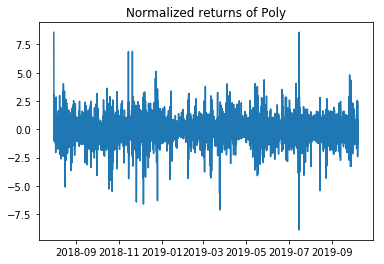

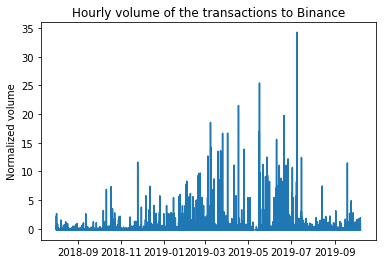

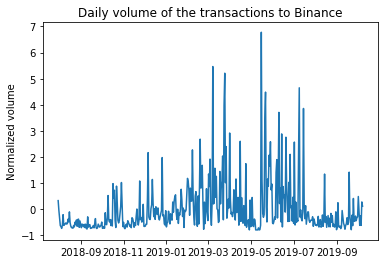

In [68]:
# We plot the transaction volume per hour and the returns
plt.plot(data.date,data.returns)
plt.title('Normalized returns of Poly')
plt.figure()
plt.plot(data.date, data.volume)
plt.title('Hourly volume of the transactions to Binance')
plt.ylabel('Normalized volume')
plt.figure()
plt.plot(daily_volume_days, daily_volume)
plt.title('Daily volume of the transactions to Binance')
plt.ylabel('Normalized volume')

In [70]:
# Let's use the python library statsmodels 
# We regress the hourly return and the transaction volume of the 
# past hour

X = np.array(data.volume).reshape(-1,1)**2
y = np.array(data.returns).reshape(-1,1)
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1004
Date:                Sat, 12 Oct 2019   Prob (F-statistic):              0.751
Time:                        19:45:03   Log-Likelihood:                -12668.
No. Observations:               10395   AIC:                         2.534e+04
Df Residuals:                   10393   BIC:                         2.535e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.008     -0.142      0.8

In [26]:
# The results show that there doesn't seem to be a relationship between the two variables

In [27]:
# Let's do the same analysis with daily data

In [73]:
# We create a daily data dataframe with the mean returns and volume
daily_data = data.resample('D', on='date').mean()

# We create also a standard deviation column with the standard deviation of the returns.
daily_data.loc[:,'std'] = data.resample('D', on='date')['returns'].std()

# We drop the rows with empty values
daily_data= daily_data.dropna()

# We recreate the index 
daily_data = daily_data.reset_index(drop=True)
daily_data.head()

,returns,volume,std
0,1.130288,0.240236,2.697856
1,0.211334,0.015641,0.903661
2,0.303590,-0.069701,0.900588
3,0.148912,-0.149062,1.183667
4,0.061677,-0.161405,0.654348


In [30]:
# We regress the daily returns and the transaction volume of the past day
X = np.array(daily_data.volume).reshape(-1,1)
y = daily_data.returns
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.635
Date:                Sat, 12 Oct 2019   Prob (F-statistic):              0.105
Time:                        19:27:53   Log-Likelihood:                 285.23
No. Observations:                 434   AIC:                            -566.5
Df Residuals:                     432   BIC:                            -558.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.006      0.211      0.8

In [31]:
# We regress the daily square returns (proxy of volatility) and the transaction volume of the past day
# Let's use the python library statsmodels
X = np.array(daily_data.volume).reshape(-1,1)
y = daily_data.returns**2
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     9.040
Date:                Sat, 12 Oct 2019   Prob (F-statistic):            0.00280
Time:                        19:27:53   Log-Likelihood:                 561.17
No. Observations:                 434   AIC:                            -1118.
Df Residuals:                     432   BIC:                            -1110.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0149      0.003      4.655      0.0

In [32]:
# The findins are extremely significant

In [33]:
# We regress the daily standard deviation of returns and the transaction volume of the day
# Let's use the python library statsmodels
X = np.array(daily_data.volume).reshape(-1,1)
y = daily_data['std']
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    std   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     40.15
Date:                Sat, 12 Oct 2019   Prob (F-statistic):           5.91e-10
Time:                        19:27:53   Log-Likelihood:                -161.93
No. Observations:                 434   AIC:                             327.9
Df Residuals:                     432   BIC:                             336.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7362      0.017     43.361      0.0

In [34]:
# The findings are extremely significant: 
# The daily standard deviation is correlated to the transaction volume to binance.

In [35]:
# Although this might be due to the fact that when time passes the coin got more popular so let's regress 
# also taking into account time. 
# -> 

time=np.array( list(range(434))).reshape(-1,1)
time=(time-time.mean())/time.std()

X=np.concatenate(
    (np.array(daily_data.volume).reshape(-1,1),time),
    axis=1)
y = daily_data['std']
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    std   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     24.32
Date:                Sat, 12 Oct 2019   Prob (F-statistic):           9.85e-11
Time:                        19:27:53   Log-Likelihood:                -158.02
No. Observations:                 434   AIC:                             322.0
Df Residuals:                     431   BIC:                             334.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7356      0.017     43.660      0.0

In [74]:
# The more time passes, the less standard deviation there is in the returns which is strange but time is not 
# very explicative